# Import libraries 

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GroupKFold
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn import model_selection
import sys
import os
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from datetime import datetime

# Important functions

In [ ]:
def metrics_test(y_real_list, y_pred_list):
    y_real = np.array(y_real_list)
    y_pred = np.array(y_pred_list)
    
    acc = accuracy_score(y_real, y_pred)
    roc_auc = roc_auc_score(y_real, y_pred)
    prc = precision_score(y_real, y_pred)
    rcl = recall_score(y_real, y_pred)
    
    return acc, roc_auc, prc, rcl

In [ ]:
def dict_intersec(dict1, dict2, option='intersec'):
    if option == 'intersec':
        return dict(set(dict1.items()) & set(dict2.items()))
    if option == 'subset':
        return dict1.items() <= dict2.items()
    else:
        raise ValueError('Unknown option was used.')

# Functions of Algorithms


**Algorithm 1**

The algorithm is based on a voting system, where each object of the positive context votes for the positive classification if its intersection with the test object is not a subset (depending on the threshold values) of the negative context and vice versa. The test object classifies positively if there are more votes for the positive classification (and vice versa). There is one threshold that controls how many intersection subsets of plus / minus and test cases can be in the minus / plus context. 


**Algorithm 2**

An algorithm based on a voting system, where each object of a positive context votes for a positive classification if its intersections (depending on the threshold) with the test object are greater than with the negative context.
The test object classifies positively if there are more votes for the positive classification (and vice versa).
It has a threshold_intersec that controls how many elements can be in positive / negative context and intersection of test cases.
This is a simpler version of Algorithm 1 because it does not search for subsets in a different context. 


**Algorithm 3**

An algorithm based on a voting system, where each plus of the context object votes for a positive classification if its intersection (depending on the threshold) with the test object is not a subset (depending on the threshold) of the negative context and vice versa. The test suite is True if there are more votes for a positive classification (and vice versa).
This algorithm is similar to Algorithm 1, but with a modification. It has a threshold_intersec that controls how many elements can be in positive / negative context and intersection of test cases. 


Algorithm 4

The algorithm classifies the test object by the maximum subset of the plus / minus context object and the intersection of the test object in the minus / plus context object. The object of verification is True if there are more votes for the positive classification (and vice versa). It has a threshold_intersec that controls how many elements can be in positive / negative context and intersection of test cases. 


In [144]:
def Alg_1(X_plus, X_minus, X_test, threshold_subset):
    norm_plus = (len(X_plus)+len(X_minus))//len(X_plus)
    norm_minus = (len(X_plus)+len(X_minus))//len(X_minus)
    y_pred = []
    random_counter = 0
    
    for ent_test in X_test:
        labels = {'plus':0, 'minus':0}
        for ent_plus in X_plus:
            counter_plus = 0 
            intersec_plus = dict_intersec(ent_test, ent_plus, option='intersec')
            for ent_minus in X_minus:
                if dict_intersec(intersec_plus, ent_minus, option='subset'):
                    counter_plus += 1
            if counter_plus <= threshold_subset:
                labels['plus'] += 1
        for ent_minus in X_minus:
            counter_minus = 0
            intersec_minus = dict_intersec(ent_test, ent_minus, option='intersec')
            for ent_plus in X_plus:
                if dict_intersec(intersec_minus, ent_plus, option='subset'):
                    counter_minus += 1
            if counter_minus <= threshold_subset:
                labels['minus'] += 1
        
        labels['plus'] = labels['plus']*norm_plus
        labels['minus'] = labels['minus']*norm_minus
        if labels['plus'] > labels['minus']:
            y_pred.append(True)
        elif labels['plus'] < labels['minus']:
            y_pred.append(False)
        else:
            random_counter += 1
            random.seed(1)
            y_pred.append(bool(random.getrandbits(1)))
    
    
    return y_pred


In [145]:
def Alg_2(X_plus, X_minus, X_test, threshold_intersec):
    y_pred = []
    random_counter = 0
    
    for ent_test in X_test:

        labels = {'plus' : 0, 'minus' : 0}
        
        for ent_plus in X_plus:
            counter_plus = 0 
            intersec_plus = dict_intersec(ent_test, ent_plus, option='intersec')
            intersec_plus_len_norm = len(intersec_plus)/len(ent_test)
            if intersec_plus_len_norm > threshold_intersec:
                labels['plus'] += 1
   
        for ent_minus in X_minus:
            counter_minus = 0
            intersec_minus = dict_intersec(ent_test, ent_minus, option='intersec')
            intersec_minus_len_norm = len(intersec_minus)/len(ent_test)
            if intersec_minus_len_norm > threshold_intersec:
                labels['minus'] += 1
                
        if labels['plus'] > labels['minus']:
            y_pred.append(True)
        elif labels['plus'] < labels['minus']:
            y_pred.append(False)
        else:
            random_counter += 1
            random.seed(1)
            y_pred.append(bool(random.getrandbits(1)))
    
    return y_pred

In [146]:
def Alg_3(X_plus, X_minus, X_test, threshold_subset, threshold_intersec):
    norm_plus = (len(X_plus)+len(X_minus))//len(X_plus)
    norm_minus = (len(X_plus)+len(X_minus))//len(X_minus)
    y_pred = []
    random_counter = 0
    
    for ent_test in X_test:
        labels = {'plus':0, 'minus':0}
        for ent_plus in X_plus:
            counter_plus = 0 
            intersec_plus = dict_intersec(ent_test, ent_plus, option='intersec')
            intersec_plus_len_norm = len(intersec_plus)/len(ent_test)
            if intersec_plus_len_norm >= threshold_intersec:
                for ent_minus in X_minus:
                    if dict_intersec(intersec_plus, ent_minus, option='subset'):
                        counter_plus += 1
                if counter_plus <= threshold_subset:
                    labels['plus'] += 1
        for ent_minus in X_minus:
            counter_minus = 0
            intersec_minus = dict_intersec(ent_test, ent_minus, option='intersec')
            intersec_minus_len_norm = len(intersec_minus)/len(ent_test)
            if intersec_minus_len_norm >= threshold_intersec:
                for ent_plus in X_plus:
                    if dict_intersec(intersec_minus, ent_plus, option='subset'):
                        counter_minus += 1
                if counter_minus <= threshold_subset:
                    labels['minus'] += 1
        
        labels['plus'] = labels['plus']*norm_plus
        labels['minus'] = labels['minus']*norm_minus
        if labels['plus'] > labels['minus']:
            y_pred.append(True)
        elif labels['plus'] < labels['minus']:
            y_pred.append(False)
        else:
            random_counter += 1
            random.seed(1)
            y_pred.append(bool(random.getrandbits(1)))
    
    return y_pred

In [147]:
def Alg_4(X_plus, X_minus, X_test, threshold_intersec):
    norm_plus = (len(X_plus)+len(X_minus))//len(X_plus)
    norm_minus = (len(X_plus)+len(X_minus))//len(X_minus)
    y_pred = []
    random_counter = 0
    
    for ent_test in X_test:

        max_counter_plus = 0
        max_counter_minus = 0
        
        for ent_plus in X_plus:
            counter_plus = 0 
            
            intersec_plus = dict_intersec(ent_test, ent_plus, option='intersec')
            intersec_plus_len_norm = len(intersec_plus)/len(ent_test)
            if intersec_plus_len_norm < threshold_intersec:
                continue
            for ent_minus in X_minus:
                if dict_intersec(intersec_plus, ent_minus, option='subset'):
                    counter_plus += 1
                    max_counter_plus = max(counter_plus, max_counter_plus)

        for ent_minus in X_minus:
            counter_minus = 0
            intersec_minus = dict_intersec(ent_test, ent_minus, option='intersec')
            intersec_minus_len_norm = len(intersec_minus)/len(ent_test)
            if intersec_minus_len_norm < threshold_intersec:
                continue
            for ent_plus in X_plus:
                if dict_intersec(intersec_minus, ent_plus, option='subset'):
                    counter_minus += 1
                    max_counter_minus = max(counter_minus, max_counter_minus)
                
        y_pred.append(max_counter_plus<max_counter_minus)

    return y_pred


# Import datasets and preparing

In [ ]:
df_congress = pd.read_csv(filepath_or_buffer="http://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data", header=None, sep=',')
columns = ['target', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
df_congress.columns = columns
df_congress = df_congress.replace('?', np.nan)
df_congress = df_congress.replace('y', True)
df_congress = df_congress.replace('n', False)
df_congress = df_congress.dropna().reset_index(drop=True)
df_congress = df_congress.replace('democrat', True)
df_congress = df_congress.replace('republican', False)
df_congress = df_congress[list(df_congress.columns.values)].astype('bool')
df_congress.info()

In [151]:
df_tic_tac = pd.read_csv(filepath_or_buffer="https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data", header=None,  sep=',')
columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 'target']
df_tic_tac.columns = columns
df_tic_tac = df_tic_tac.replace('positive', True)
df_tic_tac = df_tic_tac.replace('negative', False)
df_tic_tac = pd.get_dummies(df_tic_tac, columns=[1,2,3,4,5,6,7,8,9])
df_tic_tac = df_tic_tac[list(df_tic_tac.columns.values)].astype('bool')

In [152]:
df_tic_tac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  958 non-null    bool 
 1   1_b     958 non-null    bool 
 2   1_o     958 non-null    bool 
 3   1_x     958 non-null    bool 
 4   2_b     958 non-null    bool 
 5   2_o     958 non-null    bool 
 6   2_x     958 non-null    bool 
 7   3_b     958 non-null    bool 
 8   3_o     958 non-null    bool 
 9   3_x     958 non-null    bool 
 10  4_b     958 non-null    bool 
 11  4_o     958 non-null    bool 
 12  4_x     958 non-null    bool 
 13  5_b     958 non-null    bool 
 14  5_o     958 non-null    bool 
 15  5_x     958 non-null    bool 
 16  6_b     958 non-null    bool 
 17  6_o     958 non-null    bool 
 18  6_x     958 non-null    bool 
 19  7_b     958 non-null    bool 
 20  7_o     958 non-null    bool 
 21  7_x     958 non-null    bool 
 22  8_b     958 non-null    bool 
 23  8_o     958 non

# Experiments

### Functions of algorithms

In [ ]:
def avg_metrics(metrics):
    np_metrics = np.array(metrics)
    return np.mean(np_metrics, axis=0)

In [157]:
def print_metrics(metrics):
    print(f'Accuracy score: {metrics[0]}')
    print(f'Precision Score: {metrics[2]}')
    print(f'Roc AUC Score: {metrics[1]}')
    print(f'Recall Score: {metrics[3]}')

In [155]:
def alg_eval(df, alg_n=1, n_splits=10, is_already_cv=True, 
             threshold_subset=0, threshold_intersec=0, print_time=True):
    

    metrics = []
    y_pred_arr = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=None)
    kf.get_n_splits(df)
    X = df.drop(columns="target")
    y = df['target']
    k = 1
    for train_index, test_index in kf.split(df):

        df_train = df.iloc[train_index]
        df_test = df.iloc[test_index]


        plus_context = df_train[df_train['target'] == True]
        minus_context = df_train[df_train['target'] == False]
        
        X_plus = plus_context.drop("target", axis = 1).to_dict('records')
        X_minus = minus_context.drop("target", axis = 1).to_dict('records')


        X_test = df_test.drop("target", axis = 1).to_dict('records')
        y_test = df_test["target"].tolist()

        y_real = y_test
        if alg_n == 1:
            y_pred = Alg_1(X_plus, X_minus, X_test, threshold_subset=threshold_subset)

        if alg_n == 2:
            y_pred = Alg_2(X_plus, X_minus, X_test, threshold_intersec=threshold_intersec)

        if alg_n == 3:
            y_pred = Alg_3(X_plus, X_minus, X_test, threshold_subset=threshold_subset, threshold_intersec=threshold_intersec)

        if alg_n == 4:
            y_pred = Alg_4(X_plus, X_minus, X_test, threshold_intersec=threshold_intersec)

        acc, roc_auc, prc, rcl = metrics_test(y_pred_list=y_pred, y_real_list=y_real)
        metrics.append([acc, roc_auc, prc, rcl])
        y_pred_arr.append(y_pred)
        k += 1

    return y_pred_arr, y_real, metrics


### Experiments

In [158]:
y_pred, y_real, metrics = alg_eval(df_tic_tac)
avg_m_11 = avg_metrics(metrics)
print_metrics(avg_m_11)

Accuracy score: 0.8862719298245614
Precision Score: 0.862087501103163
Roc AUC Score: 0.8428068378861177
Recall Score: 0.9827342527386541


In [159]:
y_pred, y_real, metrics = alg_eval(df_tic_tac, alg_n=2)
avg_m_21 = avg_metrics(metrics)
print_metrics(avg_m_21)

Accuracy score: 0.6533881578947368
Precision Score: 0.6533881578947368
Roc AUC Score: 0.5
Recall Score: 1.0


In [163]:
avg_m_21

array([0.65338816, 0.5       , 0.65338816, 1.        ])

In [160]:
y_pred, y_real, metrics = alg_eval(df_tic_tac, alg_n=3)
avg_m_31 = avg_metrics(metrics)
print_metrics(avg_m_31)

Accuracy score: 0.8768640350877192
Precision Score: 0.8617909554661122
Roc AUC Score: 0.836493041382913
Recall Score: 0.9696090646710662


In [161]:
y_pred, y_real, metrics = alg_eval(df_tic_tac, alg_n=4)
avg_m_41 = avg_metrics(metrics)
print_metrics(avg_m_41)

Accuracy score: 0.816326754385965
Precision Score: 0.7802250258538844
Roc AUC Score: 0.7336933206331449
Recall Score: 1.0


In [172]:
y_pred, y_real, metrics = alg_eval(df_congress, alg_n=1)
avg_m_12 = avg_metrics(metrics)
print_metrics(avg_m_12)

Accuracy score: 0.9177536231884057
Precision Score: 0.9825757575757577
Roc AUC Score: 0.9246184371184372
Recall Score: 0.8675702075702075


In [173]:
y_pred, y_real, metrics = alg_eval(df_congress, alg_n=2)
avg_m_22 = avg_metrics(metrics)
print_metrics(avg_m_22)

Accuracy score: 0.5346014492753624
Precision Score: 0.5346014492753624
Roc AUC Score: 0.5
Recall Score: 1.0


In [174]:
y_pred, y_real, metrics = alg_eval(df_congress, alg_n=3)
avg_m_32 = avg_metrics(metrics)
print_metrics(avg_m_32)

Accuracy score: 0.913586956521739
Precision Score: 0.9909090909090909
Roc AUC Score: 0.91685168997669
Recall Score: 0.8420367132867133


In [175]:
y_pred, y_real, metrics = alg_eval(df_congress, alg_n=4)
avg_m_42 = avg_metrics(metrics)
print_metrics(avg_m_42)

Accuracy score: 0.8626811594202899
Precision Score: 1.0
Roc AUC Score: 0.8690483127983128
Recall Score: 0.7380966255966256


## Hyperparameters tuning

In [179]:
def hp_tuning(df, alg_n):
    avg_m_arr = np.empty((0,4), float)
    if alg_n == 1:
        for i in range(0,6):
            _, _, metrics = alg_eval(df, alg_n=alg_n, threshold_subset=i, print_time=False)
            avg_m = avg_metrics(metrics)
            avg_m_arr = np.vstack([avg_m_arr, avg_m])
    if alg_n in [2,3,4]:
        for i in np.arange(0, 1.1, 0.1):
            _, _, metrics = alg_eval(df, alg_n=alg_n, threshold_subset=0, threshold_intersec=i, print_time=False)
            avg_m = avg_metrics(metrics)
            avg_m_arr = np.vstack([avg_m_arr, avg_m])
    
    return avg_m_arr

### First dataset tic_tac_toe

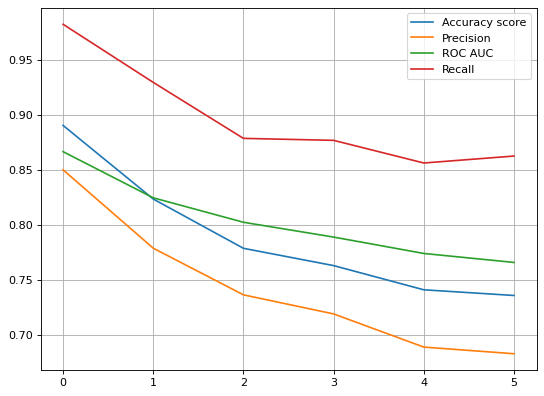

In [181]:
avg_tune_11 = hp_tuning(df_tic_tac, alg_n=1)
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(avg_tune_11)
plt.legend(['Accuracy score', 'Precision', 'ROC AUC','Recall'])
plt.grid()
plt.show()

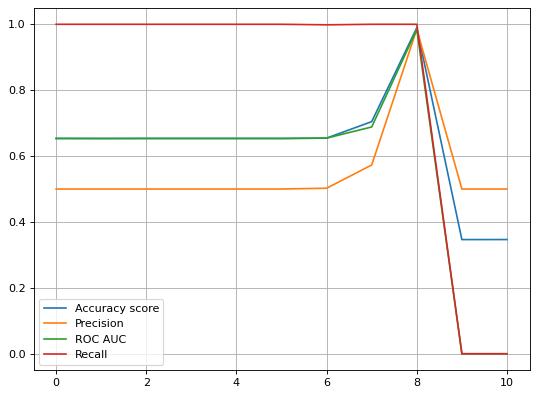

CPU times: user 1min 20s, sys: 234 ms, total: 1min 20s
Wall time: 1min 33s


In [183]:
%%time
avg_tune_12 = hp_tuning(df_tic_tac, alg_n=2)
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(avg_tune_12)
plt.legend(['Accuracy score', 'Precision', 'ROC AUC','Recall'])
plt.grid()
plt.show()

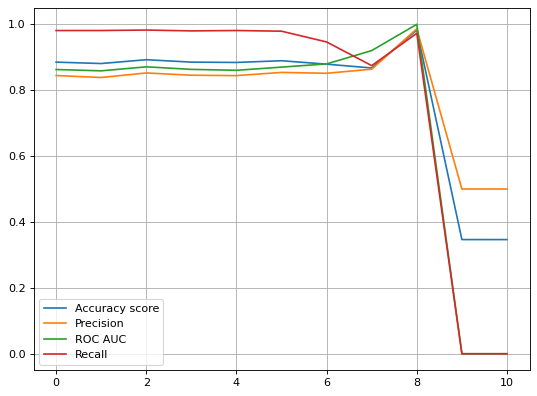

CPU times: user 18min 31s, sys: 2.49 s, total: 18min 34s
Wall time: 18min 57s


In [184]:
%%time
avg_tune_13 = hp_tuning(df_tic_tac, alg_n=3)
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(avg_tune_13)
plt.legend(['Accuracy score', 'Precision', 'ROC AUC','Recall'])
plt.grid()
plt.show()

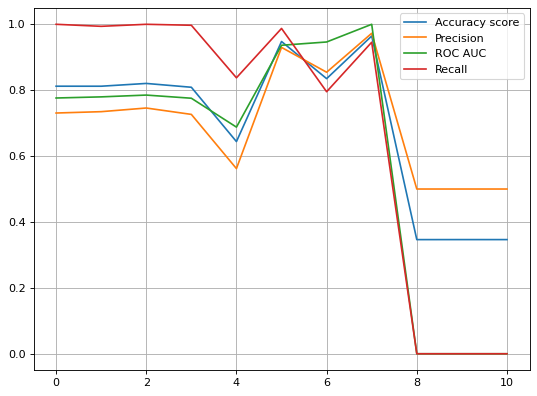

CPU times: user 17min 59s, sys: 2.31 s, total: 18min 2s
Wall time: 18min 11s


In [185]:
%%time
avg_tune_14 = hp_tuning(df_tic_tac, alg_n=4)
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(avg_tune_14)
plt.legend(['Accuracy score', 'Precision', 'ROC AUC','Recall'])
plt.grid()
plt.show()

### Second dataset

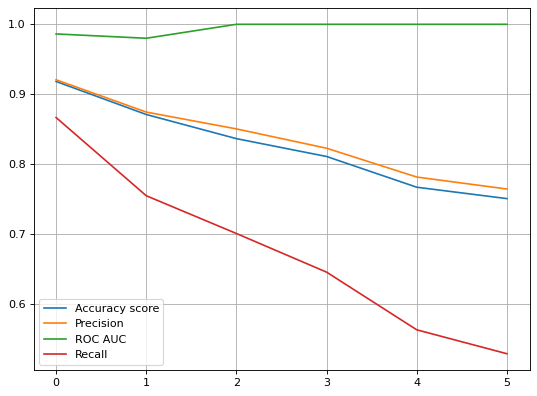

CPU times: user 16.3 s, sys: 30 ms, total: 16.4 s
Wall time: 16.4 s


In [186]:
%%time
avg_tune_21 = hp_tuning(df_congress, alg_n=1)
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(avg_tune_21)
plt.legend(['Accuracy score', 'Precision', 'ROC AUC','Recall'])
plt.grid()
plt.show()

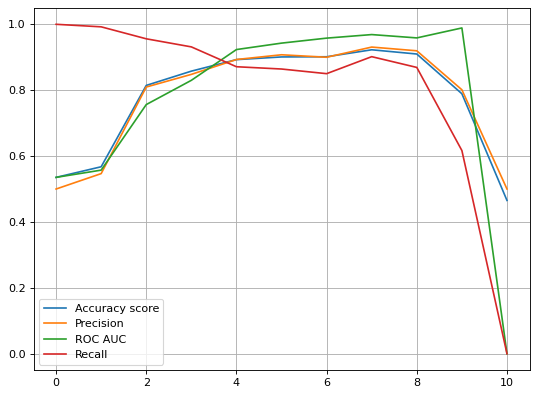

CPU times: user 3.6 s, sys: 23.4 ms, total: 3.62 s
Wall time: 3.62 s


In [187]:
%%time
avg_tune_22 = hp_tuning(df_congress, alg_n=2)
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(avg_tune_22)
plt.legend(['Accuracy score', 'Precision', 'ROC AUC','Recall'])
plt.grid()
plt.show()

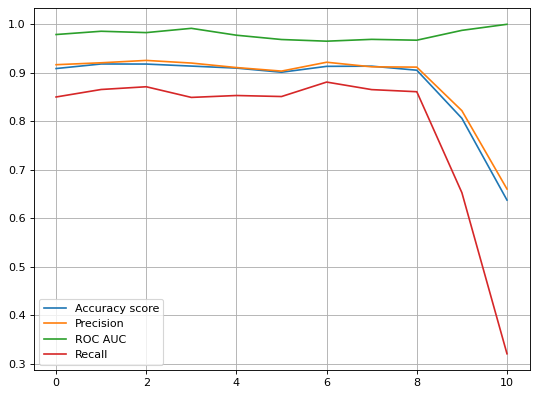

CPU times: user 17.6 s, sys: 54 ms, total: 17.7 s
Wall time: 17.7 s


In [188]:
%%time
avg_tune_23 = hp_tuning(df_congress, alg_n=3)
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(avg_tune_23)
plt.legend(['Accuracy score', 'Precision', 'ROC AUC','Recall'])
plt.grid()
plt.show()

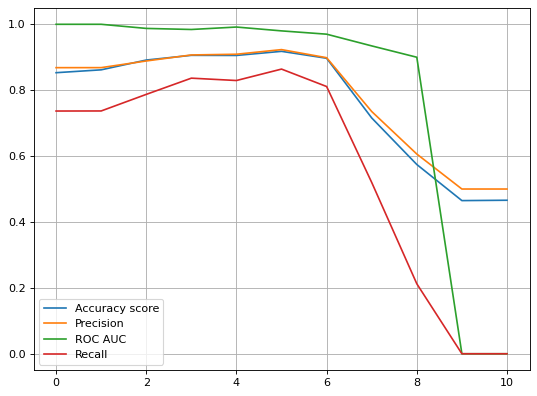

CPU times: user 17.7 s, sys: 37.8 ms, total: 17.7 s
Wall time: 17.7 s


In [189]:
%%time
avg_tune_24 = hp_tuning(df_congress, alg_n=4)
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(avg_tune_24)
plt.legend(['Accuracy score', 'Precision', 'ROC AUC','Recall'])
plt.grid()
plt.show()

## Comparison with Beroulli Naive Bayes

In [194]:
from sklearn.naive_bayes import BernoulliNB

In [205]:
def bernoulliNB(df):
    y_pred_arr = []
    metrics = []

    kf = KFold(n_splits=10, shuffle=True, random_state=None)
    kf.get_n_splits(df)
    X = df.drop(columns="target")
    y = df['target']
    k = 1
    for train_index, test_index in kf.split(df):

        df_train = df.iloc[train_index]
        df_test = df.iloc[test_index]
        
        X_train = df_train.drop('target', axis = 1).to_numpy()
        y_train = df_train['target'].to_numpy()
        
        X_test = df_test.drop('target', axis = 1).to_numpy()
        y_test = df_test['target'].to_numpy()
        
        clf = BernoulliNB()
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)

        acc, roc_auc, prc, rcl = metrics_test(y_pred_list=y_pred, y_real_list=y_test.tolist())
        metrics.append([acc, roc_auc, prc, rcl])
        y_pred_arr.append(y_pred)
    
        
    return y_pred_arr, y_test, metrics

In [206]:
%%time
y_pred, y_real, metrics = bernoulliNB(df_tic_tac)
avg_bNB_1 = avg_metrics(metrics)
print_metrics(avg_bNB_1)

Accuracy score: 0.6941557017543861
Precision Score: 0.7439255230001468
Roc AUC Score: 0.6440519087189365
Recall Score: 0.8115430252888457
CPU times: user 55.9 ms, sys: 0 ns, total: 55.9 ms
Wall time: 57.3 ms


In [207]:
%%time
y_pred, y_real, metrics = bernoulliNB(df_congress)
avg_bNB_2 = avg_metrics(metrics)
print_metrics(avg_bNB_2)

Accuracy score: 0.909963768115942
Precision Score: 0.9356410256410257
Roc AUC Score: 0.916747002997003
Recall Score: 0.8916758241758241
CPU times: user 50.5 ms, sys: 903 µs, total: 51.4 ms
Wall time: 53.1 ms


# Plot results

In [227]:
avg_metrics_tic_tac_toe_full = np.vstack([np.mean(avg_tune_11, axis=0), np.mean(avg_tune_12, axis=0), np.mean(avg_tune_13, axis=0), np.mean(avg_tune_14, axis=0), avg_bNB_1])
avg_metrics_congress_full = np.vstack([np.mean(avg_tune_21, axis=0), np.mean(avg_tune_22, axis=0), np.mean(avg_tune_23, axis=0), np.mean(avg_tune_24, axis=0), avg_bNB_2])

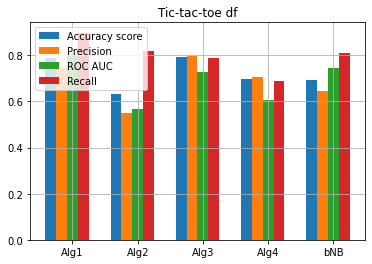

In [226]:
x = np.arange(avg_metrics_tic_tac_toe_full.shape[0])
dx = (np.arange(avg_metrics_tic_tac_toe_full.shape[1])-avg_metrics_tic_tac_toe_full.shape[1]/2.)/(avg_metrics_tic_tac_toe_full.shape[1]+2.)
d = 1./(avg_metrics_tic_tac_toe_full.shape[1]+2.)


fig, ax=plt.subplots()
labels = ['Alg1','Alg2','Alg3','Alg4','bNB']
x_axis = np.arange(0, 5, 1)
for i in range(avg_metrics_tic_tac_toe_full.shape[1]):
    ax.bar(x+dx[i],avg_metrics_tic_tac_toe_full[:,i], width=d)#, label="label {}".format(labels[i]))
plt.xticks(x_axis,labels)
plt.title("Tic-tac-toe df")
plt.legend((['Accuracy score', 'Precision', 'ROC AUC','Recall']))
plt.grid()
plt.show()


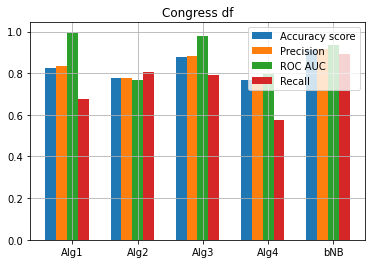

In [228]:
x = np.arange(avg_metrics_congress_full.shape[0])
dx = (np.arange(avg_metrics_congress_full.shape[1])-avg_metrics_congress_full.shape[1]/2.)/(avg_metrics_tic_tac_toe_full.shape[1]+2.)
d = 1./(avg_metrics_congress_full.shape[1]+2.)


fig, ax=plt.subplots()
labels = ['Alg1','Alg2','Alg3','Alg4','bNB']
x_axis = np.arange(0, 5, 1)
for i in range(avg_metrics_congress_full.shape[1]):
    ax.bar(x+dx[i],avg_metrics_congress_full[:,i], width=d)#, label="label {}".format(labels[i]))
plt.xticks(x_axis,labels)
plt.title("Congress df")
plt.legend((['Accuracy score', 'Precision', 'ROC AUC','Recall']))
plt.grid()
plt.show()

# Results

The best algorithm for **tic_tac_toe** is **First algorithm** by accuracy

The best algorithm for **congress dataset** is **Second algorithm** by accuracy
